## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
misalign_1 = df.query('landing_page =="old_page" and  group=="treatment"').count()
misalign_2= df.query('landing_page =="new_page" and  group=="control"').count()
misalign = misalign_1 + misalign_2
print(misalign)

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store our new dataframe in **df2**.

In [8]:
df_temp_1 = df.query('landing_page =="new_page" and  group=="treatment"')
df_temp_2 = df.query('landing_page =="old_page" and  group=="control"')
df2= df_temp_1.append(df_temp_2)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicate = df2[df2.duplicated(['user_id'], keep=False)]

c. What is the row information for the repeat **user_id**? 

In [12]:
print(duplicate)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. Remove **one** of the rows with a duplicate **user_id**, but keep our dataframe as **df2**.

In [13]:
#Keep the first instance
df2= df2.drop_duplicates(['user_id'],keep='first');

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group =="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group =="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if we think there is evidence that one page leads to more conversions?  

Both type of users are equally as liquely to view the new and the old page, thus we have more or less the same sample size. At this point we can suggest that the new treatment page leads to more conversions but we do not know the signficance of these results yet.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$
\begin{array}{c}
H_0: p_{new} \le p_{old} \\\
H_1: p_{new} > p_{old}\\\
\end{array}
$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
print(p_new)

0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
print(p_old)

0.11959708724499628


c. What is $n_{new}$?

In [23]:
n_new =df2[df2['group'] == "treatment"].shape[0]
print(n_new)

145310


d. What is $n_{old}$?

In [24]:
n_old=df2[df2['group'] == "control"].shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(n_new, p_new)
print(new_page_converted)

17441


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n_old, p_old)
print(old_page_converted)

17105


g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [27]:
diff = p_new - p_old
print(diff)

0.0


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
# create sampling distribution of difference in average conversion
# Use boostrapping
p_diffs = []
for _ in range(10000):
    new_page_convert = np.random.binomial(n_new, p_new)/n_new
    old_page_convert = np.random.binomial(n_old, p_old)/n_old
    p_diffs.append(new_page_convert - old_page_convert)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what we expected? 

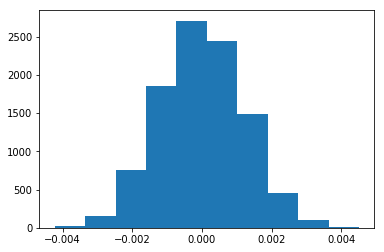

In [30]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#Convert p_diffs to an array
p_diffs = np.array(p_diffs)
#Get the actual difference in "ab_data.csv"
ab_data_diff = df[df['group'] =='treatment']['converted'].mean() - df[df['group'] =='control']['converted'].mean()
#Calculate the difference
(ab_data_diff <p_diffs).mean()

0.88880000000000003

k. Explain what we just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

What we just computed is the p value: the probability of obtaining a result equal to or more extreme to the alternative when the null hypothesis is actually true. For our result to be statistcally signficiant is preferable for p <= 0.05. We fail to reject the null hypothesis.
l.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == True')['converted'].count()
convert_new = df2.query('landing_page == "new_page" and converted == True')['converted'].count()
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()

/Users/nadimkawwa/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute our test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='two-sided')
print (z_score, p_value)

1.31092419842 0.189883374482


In [34]:
from scipy.stats import norm
#Determine how significiant z score is
norm.cdf(z_score)

0.90505831275902449

In [35]:
#Determine ciritcal value at 95% confidence
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

We obtain a large p value again, we fail to reject the null hypothesis. These results are similar to the ones in j and k.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

The output is categorical and can only take two values: 1 or 0. Use logistic regression.


b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] =1

In [37]:
df2 [['control', 'ab_page']]= pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


In [38]:
#Drop the control column to keep matrix full rank
df2 = df2.drop('control', axis=1)

c. Use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [39]:
import statsmodels.api as sm
from scipy import stats

#This line is a workaround an attribute error regarding 'chisqprob' when running results.summary().
#The line of code is taken from  github: (https://github.com/statsmodels/statsmodels/issues/3931).
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of our model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:36:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in the **Part II**?<br><br> What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p value for ab_page is 0.190 which against a 5% tolerance for type 1 errors means we fail to reject the null hypthesis. This is also a two tailed test whereas the test part II was a one tailed test.

f. Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

It might be a good idea to identify other items that might have an impact if an individual converts, such as the time stamps. Did the control and treatment group both see the pages at same times of day? The disadvantages might be if one or more of the regression factors are a funciton of one another. We might also face Simpson's paradox based on how we aggregate the groups.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. we will need to read in the **countries.csv** dataset and merge together our datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns<br> 
We will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
#Make Canada the baseline
df_new[['US', 'UK']] = pd.get_dummies(df_new['country'])[['US', 'UK']]

In [43]:
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,0,0
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,0,1


h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and our conclusions based on the results.

In [44]:
# Fit our Linear Model And Obtain the Results
logit_new = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results_new = logit_new.fit()
results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        16:36:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

For US the p value is 0.129 and for UK it is 0.074. Based on the country we fail to reject the null hypothesis.

## Directions to Submit

> Run run the code cell below to create a .html or .pdf version of this notebook in the workspace here. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])